# Load packages

In [1]:
import re
import os
import sys
import gzip
import torch
import numpy as np
import pandas as pd
import scanpy as sc
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel, GPT2Model

# Setting parameter and file path

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu" 
tokenizer_file = "lixiangchun/transcriptome-gpt-1024-8-16-64" 
checkpoint = "lixiangchun/transcriptome-gpt-1024-8-16-64" ## Pretrained model
celltype_path = "./data/Muris_cell_labels.txt.gz" ## Cell type annotation
max_len = 64 ## Number of top genes used for analysis
text_file = "./data/Muris_gene_rankings.txt.gz"  ## Gene symbols ranked by exprssion

# Extract features

In [3]:
class LineDataset(Dataset):
    def __init__(self, lines):
        self.lines = lines
        self.regex = re.compile(r'\-|\.')
    def __getitem__(self, i):
        return self.regex.sub('_', self.lines[i])
    def __len__(self):
        return len(self.lines)

tokenizer = PreTrainedTokenizerFast.from_pretrained(tokenizer_file)
model = GPT2LMHeadModel.from_pretrained(checkpoint,output_hidden_states = True).transformer
model = model.to(device)
model.eval()

lines = [s.decode().strip() for s in gzip.open(text_file, "r").readlines()]

ds = LineDataset(lines)
dl = DataLoader(ds, batch_size=64)

Xs = []
for a in tqdm(dl, total=len(dl)):
    batch = tokenizer(a, max_length= max_len, truncation=True, padding=True, return_tensors="pt")

    for k, v in batch.items():
        batch[k] = v.to(device)

    with torch.no_grad():
        x = model(**batch)
    
    eos_idxs = batch.attention_mask.sum(dim=1) - 1
    xx = x.last_hidden_state
       
    result_list = [[] for i in range(len(xx))]

    for j, item in enumerate(xx):
        result_list[j] = item[1:int(eos_idxs[j]),:].mean(dim =0).tolist()
        
    Xs.extend(result_list)
    
features = np.stack(Xs)

Downloading:   0%|          | 0.00/158 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/302k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/736 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

100%|██████████| 858/858 [04:36<00:00,  3.10it/s]


# Visualization

In [4]:
adata=sc.AnnData(features)
celltype = pd.read_csv(celltype_path, header=None)[0].tolist()
adata.obs["celltype"] = celltype
adata.obs["celltype"] = adata.obs["celltype"].astype("category")

sc.pp.neighbors(adata,n_neighbors=20)
sc.tl.leiden(adata,resolution=0.6)
sc.tl.umap(adata)

/media/storage1/software/install/miniconda37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """Entry point for launching an IPython kernel.
         Falling back to preprocessing with `sc.pp.pca` and default params.
/home/shenhongru/.local/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.
  warnings.warn(problem)


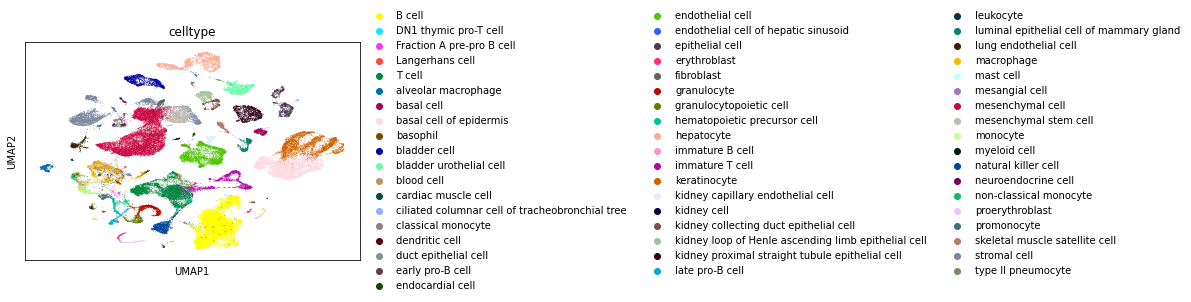

In [5]:
#################  Cell Type  #######################
sc.pl.umap(adata, color = ["celltype"], show = True)

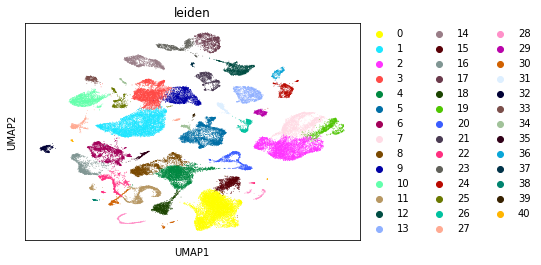

In [6]:
############ Single-cell Clustering  #############
sc.pl.umap(adata, color = ["leiden"], show = True)

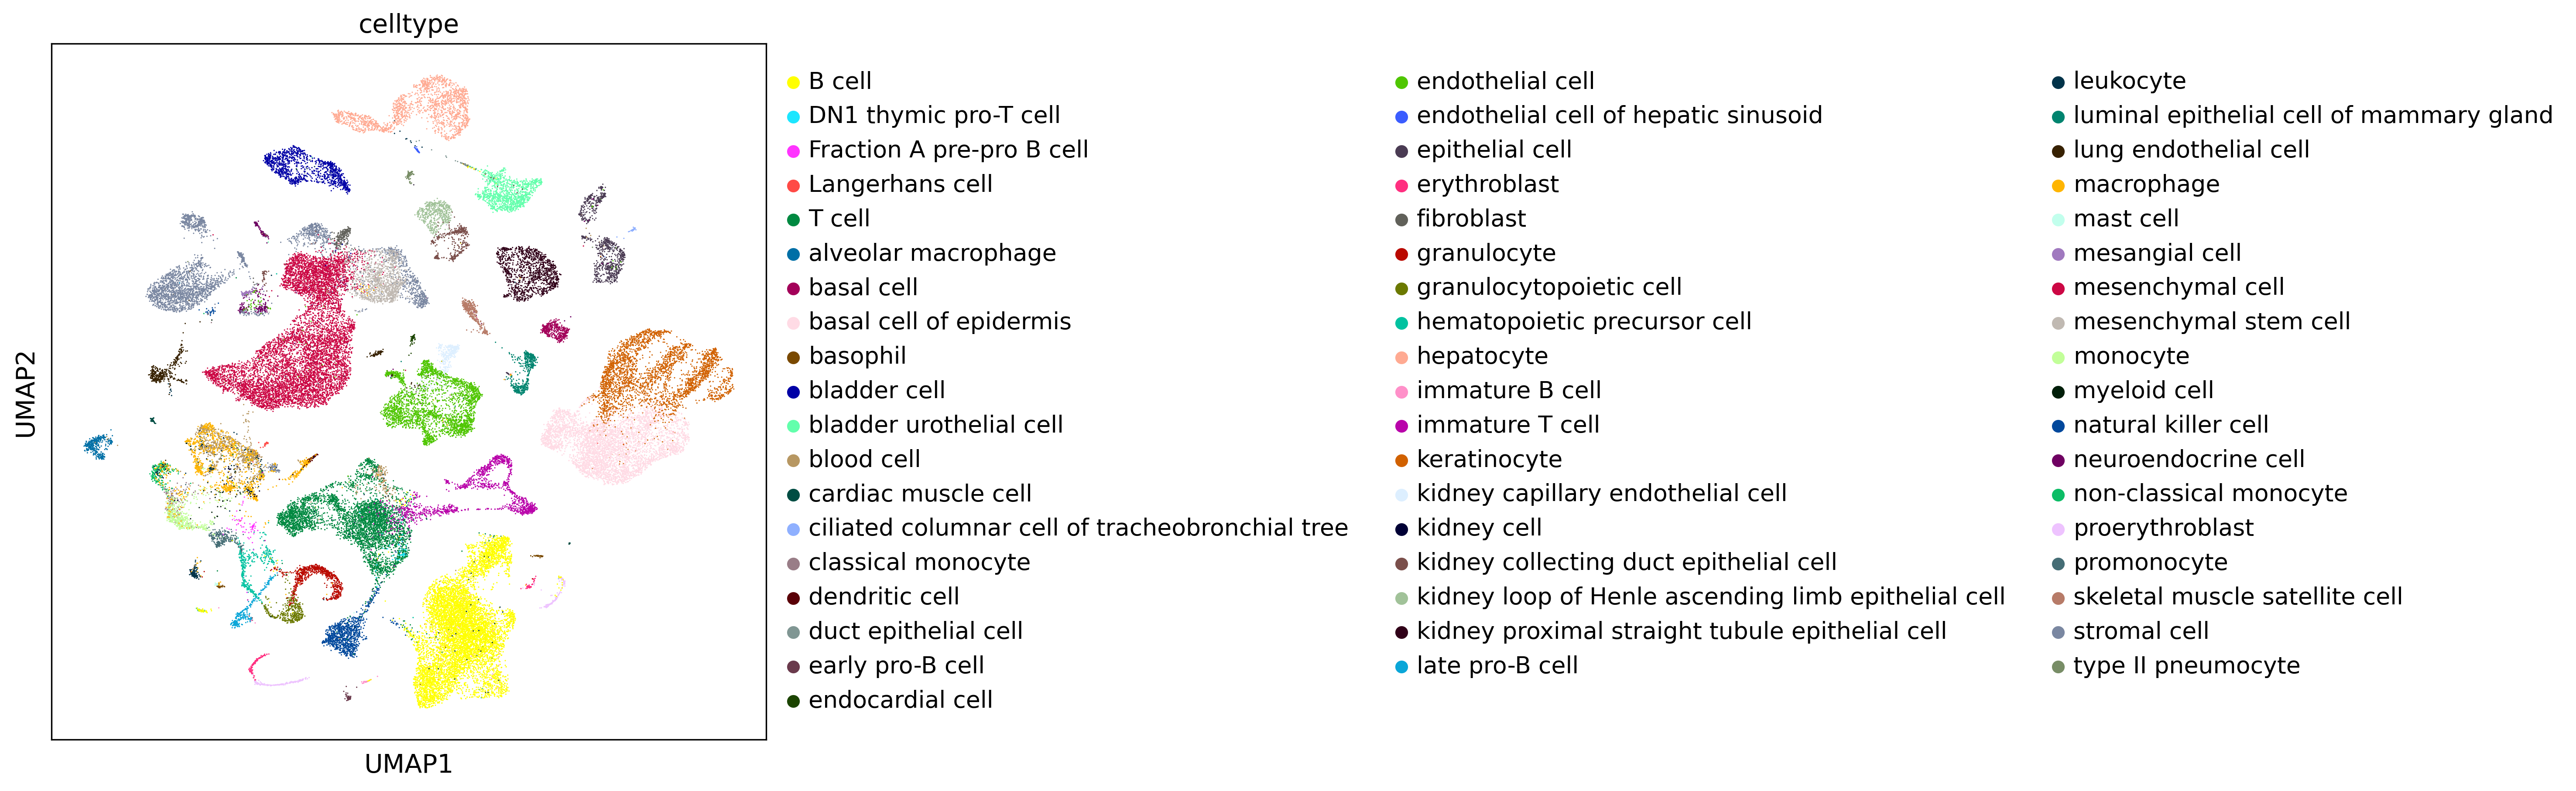

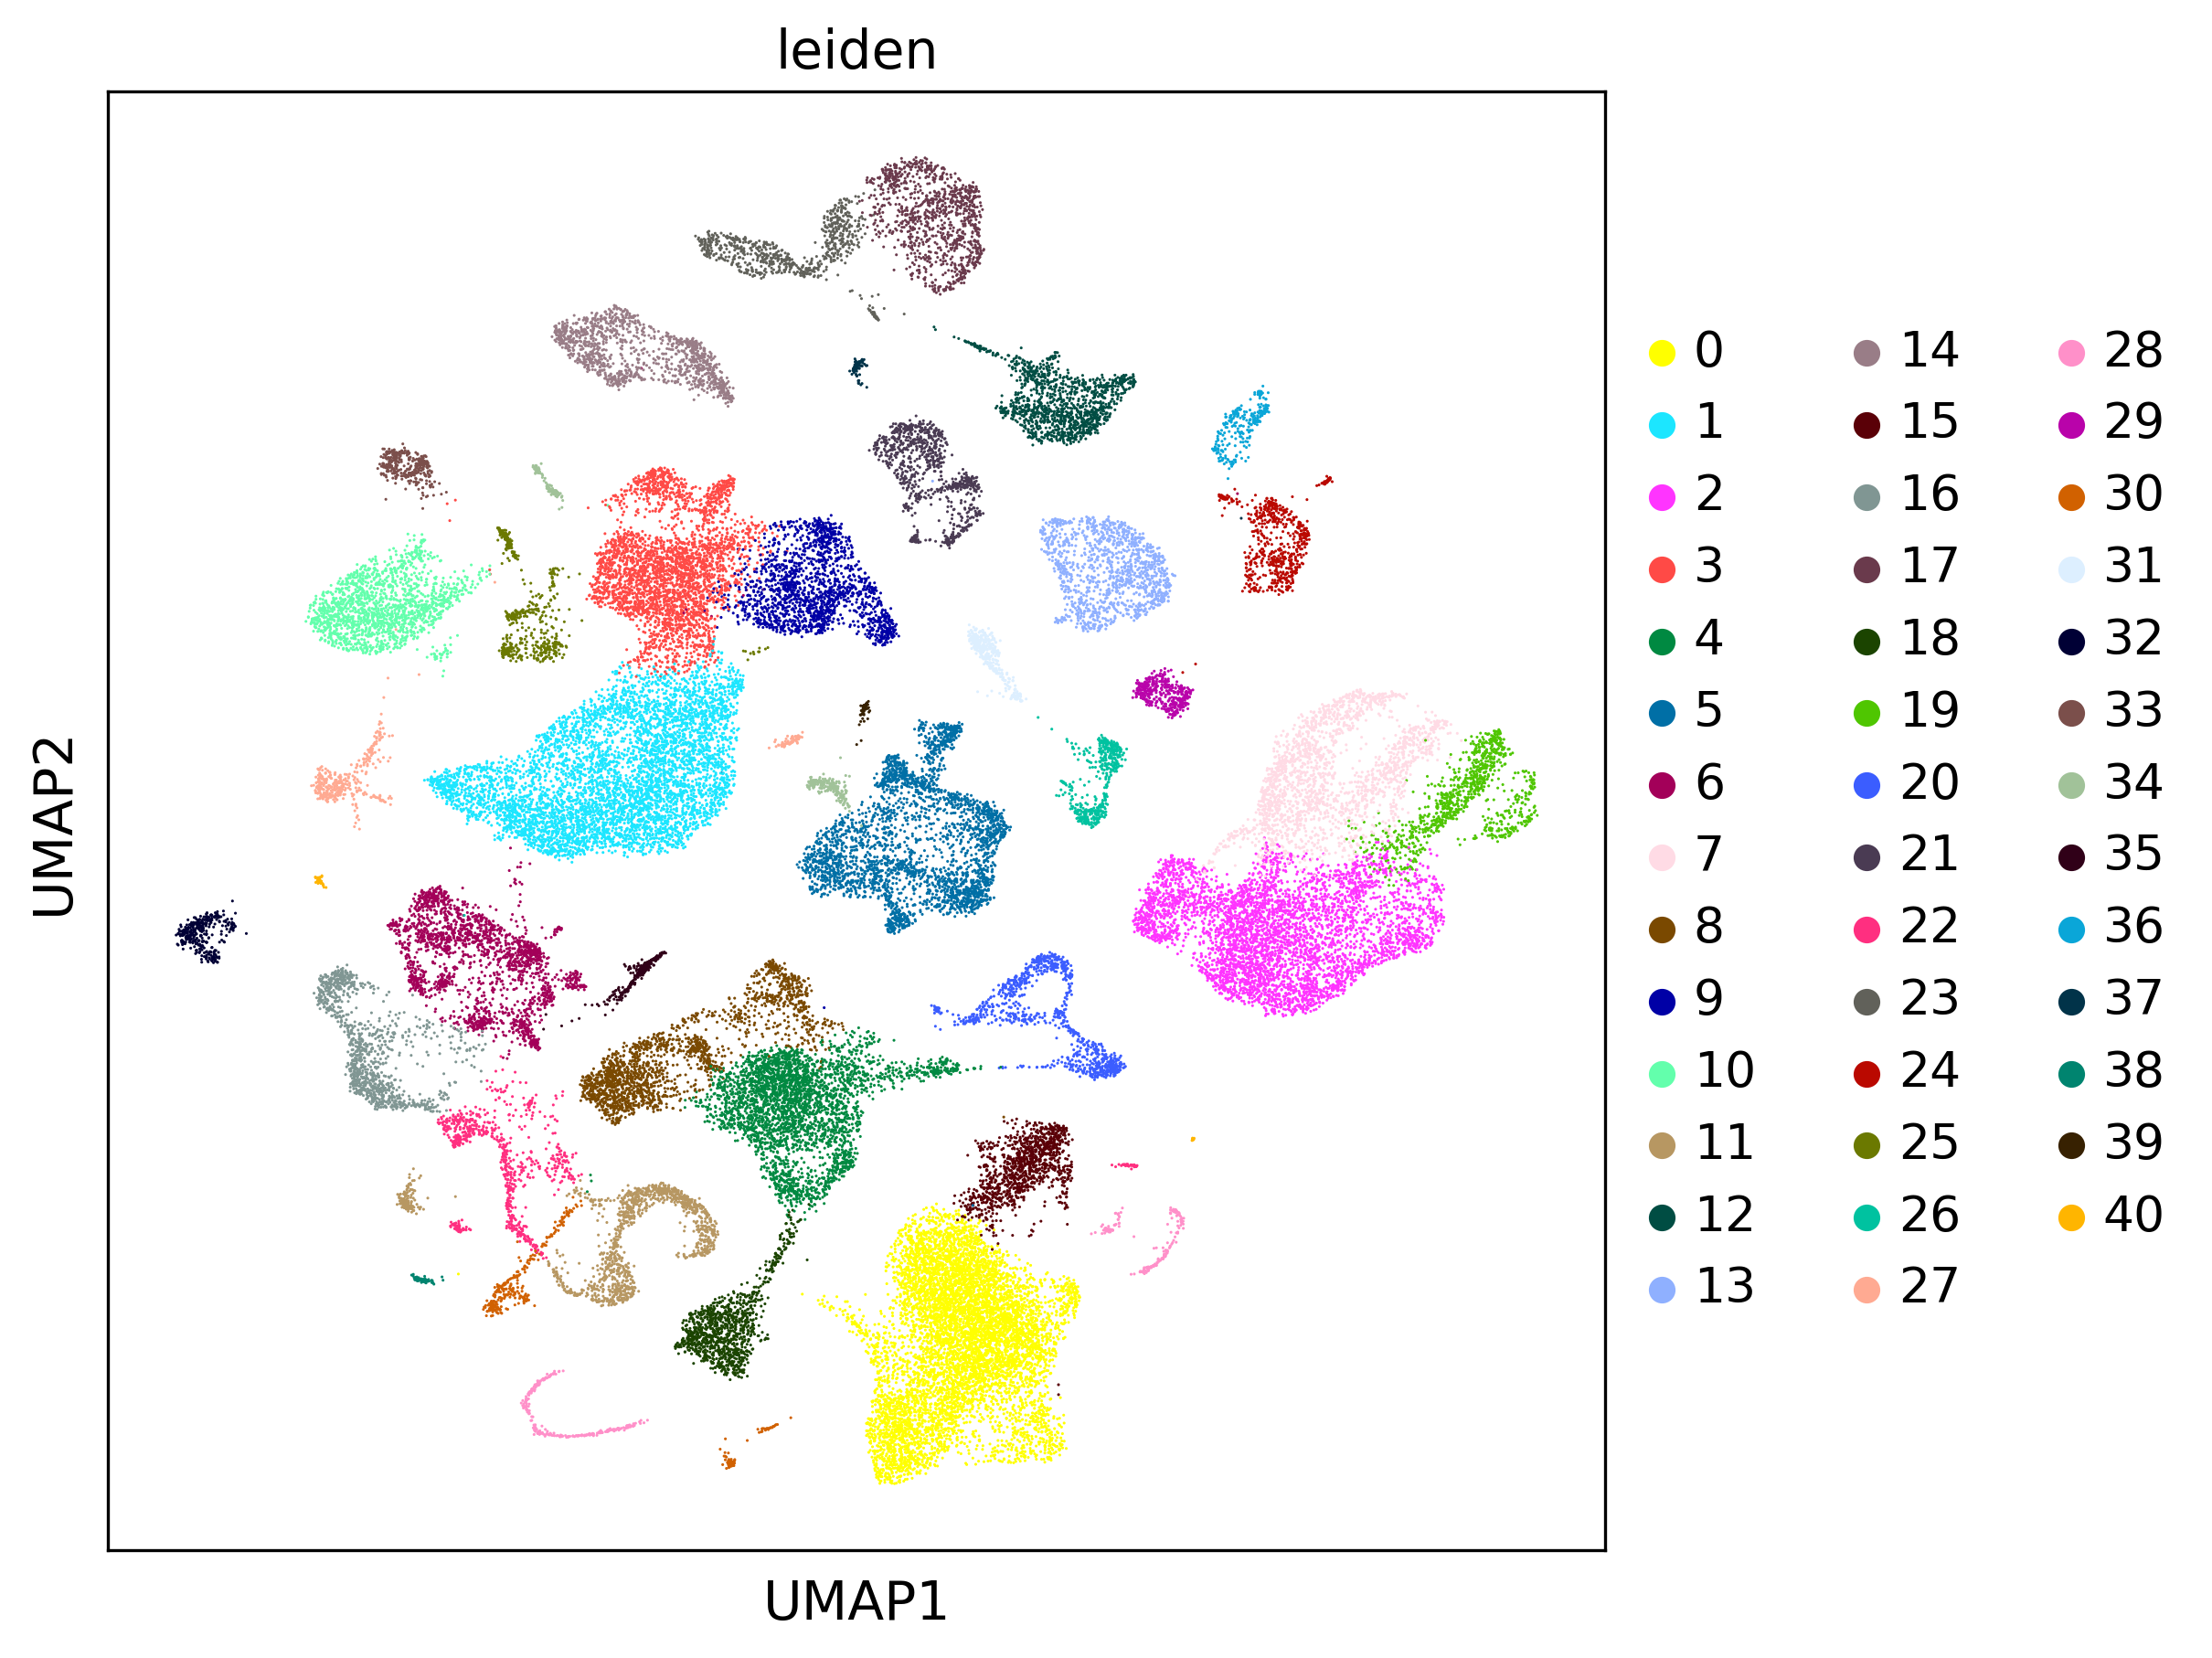

In [7]:
sc.set_figure_params(dpi=300,figsize=(7,7))
sc.pl.umap(adata, color = ["celltype"], save="celltype.png")
sc.pl.umap(adata, color = ["leiden"], save="leiden.png")